In [1]:
# import library
import argparse,copy,h5py, os,sys,time,socket
import numpy as np
import tensorflow as tf
import torch,torchvision,torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from   torchsummary import summary
from   torch.autograd.variable import Variable

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import ticker,colors

# seed value and plotly
init_notebook_mode(connected=True); torch.manual_seed(7); torch.cuda.manual_seed_all(7); np.set_printoptions(suppress=True,precision=3,); tf.set_random_seed(7)

In [74]:
# create viz
def create_viz(loss_list,acc_list,title="none"):
    
    numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0

    xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
    ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 

    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
    # plot the loss functions
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title("Original Contour")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    plt.clabel(CS, inline=1, fontsize=8)

    plt.subplot(132)
    plt.title("Original Contour with Color")
    plt.contour(xcoord_mesh, ycoord_mesh, loss_list,  10, zorder=1, cmap='terrain', linestyles='--')
    CS = plt.contourf(xcoord_mesh, ycoord_mesh, loss_list, 10, zorder=1, cmap='terrain', linestyles='--')   
    plt.clabel(CS, fontsize=12,inline=0,fmt = '%2.1f')
    plt.colorbar(CS)

    plt.subplot(133)
    plt.title("Log Scale")
    CS = plt.contour(xcoord_mesh, ycoord_mesh, np.log(loss_list+1e-8),10,zorder=1, cmap='terrain', linestyles='--'); 
    plt.clabel(CS, fontsize=8,inline=1)

    plt.savefig(title)
    plt.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(loss_list.max()-loss_list.min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+loss_list.min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,
            z=(np.log(loss_list).max()-np.log(loss_list).min())*(acc_list-acc_list.min())/(acc_list.max()-acc_list.min()+1e-8)+np.log(loss_list).min(),
            showscale=False, opacity=0.6,colorscale='Cividis',
        ),
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(loss_list),colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Log Scale Loss / Accuracy',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()
def overlap_three(a_loss_list_1,b_loss_list_1,c_loss_list_1):
    numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0
    xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
    ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=a_loss_list_1,colorscale='Blues',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=b_loss_list_1,colorscale='Greens',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=c_loss_list_1,colorscale='Reds',opacity=0.5,showscale=False
        )
    ]
    layout = go.Layout(title='Loss Landscape',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(a_loss_list_1),colorscale='Blues',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(b_loss_list_1),colorscale='Greens',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(c_loss_list_1),colorscale='Reds',opacity=0.5,showscale=False
        )
    ]
    layout = go.Layout(title='Loss Landscape Log Scale',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

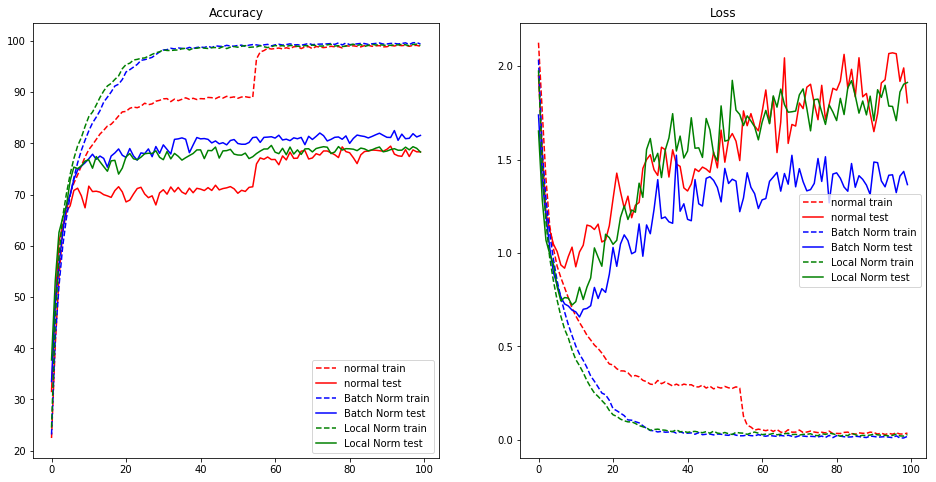

In [84]:
# plot accuracy
a_acurracy_list_train = np.load("./a/a_acurracy_list_train.npy")
a_acurracy_list_test  = np.load("./a/a_acurracy_list_test.npy")

b_acurracy_list_train = np.load("./b/b_acurracy_list_train.npy")
b_acurracy_list_test  = np.load("./b/b_acurracy_list_test.npy")

c_acurracy_list_train = np.load("./c/c_acurracy_list_train.npy")
c_acurracy_list_test  = np.load("./c/c_acurracy_list_test.npy")

a_loss_list_train = np.load("./a/a_loss_list_train.npy")
a_loss_list_test  = np.load("./a/a_loss_list_test.npy")

b_loss_list_train = np.load("./b/b_loss_list_train.npy")
b_loss_list_test  = np.load("./b/b_loss_list_test.npy")

c_loss_list_train = np.load("./c/c_loss_list_train.npy")
c_loss_list_test  = np.load("./c/c_loss_list_test.npy")

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(a_acurracy_list_train,linestyle='dashed' ,color='red',label="normal train")
plt.plot(a_acurracy_list_test,color='red',label="normal test")

plt.plot(b_acurracy_list_train,color='blue',linestyle='dashed',label="Batch Norm train")
plt.plot(b_acurracy_list_test,color='blue',label="Batch Norm test")

plt.plot(c_acurracy_list_train,color='green',linestyle='dashed',label="Local Norm train")
plt.plot(c_acurracy_list_test,color='green',label="Local Norm test")
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(a_loss_list_train,color='red',linestyle='dashed',label="normal train")
plt.plot(a_loss_list_test,color='red',label="normal test")

plt.plot(b_loss_list_train,color='blue',linestyle='dashed',label="Batch Norm train")
plt.plot(b_loss_list_test,color='blue',label="Batch Norm test")

plt.plot(c_loss_list_train,color='green',linestyle='dashed',label="Local Norm train")
plt.plot(c_loss_list_test,color='green',label="Local Norm test")

plt.legend()
plt.show()

In [72]:
# plot loss landscape
a_acc_list_1  = np.load('./a/a_acc_list_1.npy')
a_loss_list_1 = np.load('./a/a_loss_list_1.npy')

b_acc_list_1  = np.load('./b/b_acc_list_1.npy')
b_loss_list_1 = np.load('./b/b_loss_list_1.npy')

c_acc_list_1  = np.load('./c/c_acc_list_1.npy')
c_loss_list_1 = np.load('./c/c_loss_list_1.npy')

# create_viz(a_loss_list_1,a_acc_list_1)

In [73]:
def overlap_three(a_loss_list_1,b_loss_list_1,c_loss_list_1):
    numebr_of_points = 21 ; small_range = -1.0 ; large_range =  1.0
    xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
    ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=a_loss_list_1,colorscale='Blues',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=b_loss_list_1,colorscale='Greens',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=c_loss_list_1,colorscale='Reds',opacity=0.5,showscale=False
        )
    ]
    layout = go.Layout(title='Loss Landscape',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()

    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(a_loss_list_1),colorscale='Blues',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(b_loss_list_1),colorscale='Greens',opacity=0.5,showscale=False
        ),

        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=np.log(c_loss_list_1),colorscale='Reds',opacity=0.5,showscale=False
        )
    ]
    layout = go.Layout(title='Loss Landscape Log Scale',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); iplot(fig); plt.show()